Building the Tweeter and Lyot pupil mask using the pupil plane's amplitude cut-off

In [1]:
import numpy as np
from astropy import units as u
from astropy.io import fits
import copy
from matplotlib import pyplot as plt

import poppy
from model_kit import magaoxFunctions as mf

In [2]:
# declare MagAO-X variables
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 512, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'surf_off': True,
           'n_tests': 10}

wavelen = np.round(fr_parm['wavelength'].to(u.nm).value).astype(int)
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2:3}nm'.format(fr_parm['npix'], br, wavelen)

# load the CSV prescription values
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
rx_loc = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}.csv'.format(parm_name)
rx_sys = mf.makeRxCSV(rx_loc, print_names=False)

# acquiring csv numerical values for specifically named optics
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Type'] == 'mirror' or 'DM': # remove surfaces
        rx_sys[t_optic][6] = 'none' # file folder
        rx_sys[t_optic][7] = 'none' # file name
    #if test_opt['Name'] == 'OAP-0':
    #    rx_sys[t_optic][3] = 0.14355 # Zemax focal length
    #if test_opt['Name'] == 'Woofer':
    #    rx_sys[t_optic][4] = 0.144693 # Zemax distance
    if test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
        vapp_diam = test_opt['Radius_m']*2*u.m
    if test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']

Text(0.5, 1.0, 'Magellan Pupil')

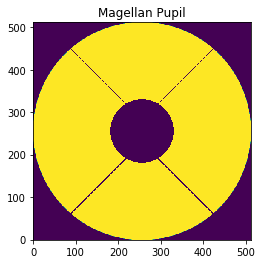

In [3]:
# build the Magellan pupil
entrance_radius = 3.25*u.m
m1_ap = poppy.CircularAperture(name='circ', radius = entrance_radius)
secobs = poppy.AsymmetricSecondaryObscuration(secondary_radius=np.around(entrance_radius*0.29, decimals=4),
                                              support_angle=[45,135, -45, -135],
                                              support_width=[0.01905, 0.0381,0.01905, 0.0381],
                                              support_offset_x= 0,
                                              support_offset_y= [0.34, -0.34, 0.34, -0.34])
m1_pupil = poppy.CompoundAnalyticOptic(opticslist=[m1_ap, secobs], name='Mag pupil')
wf = poppy.poppy_core.Wavefront(npix=fr_parm['npix'], diam=entrance_radius*2, 
                                wavelength=fr_parm['wavelength'])
pupil_mask = m1_pupil.get_transmission(wf)

plt.imshow(pupil_mask, origin='lower')
plt.title('Magellan Pupil')

### Tweeter Plane analysis

In [4]:
%%time
n=0
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='Tweeter')
tw_psf, tw_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

CPU times: user 24.2 s, sys: 7.14 s, total: 31.4 s
Wall time: 14.4 s


Text(0.5, 1.0, 'Tweeter phase with pupil mask')

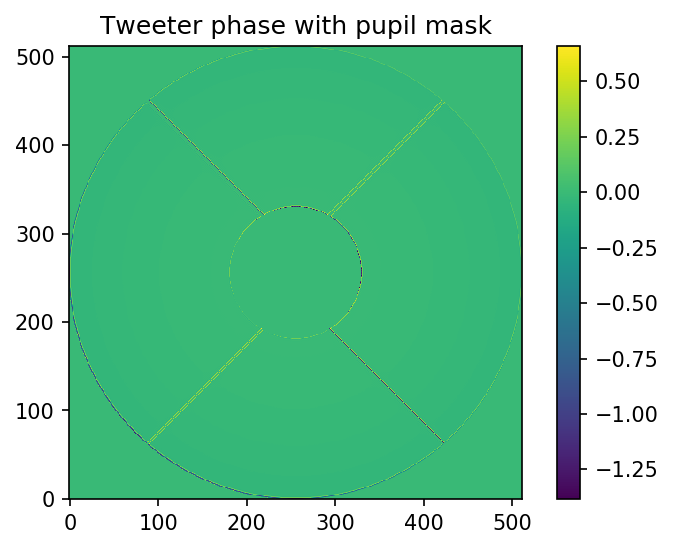

In [5]:
tw_ph = poppy.utils.pad_or_crop_to_shape(tw_wf[0].phase, (fr_parm['npix'], fr_parm['npix']))
tw_ph_qm = tw_ph*np.flipud(pupil_mask)
plt.figure(dpi=150)
plt.imshow(tw_ph_qm, origin='lower')
plt.colorbar()
plt.clim(np.amin(tw_ph_qm), np.amax(tw_ph_qm))
plt.title('Tweeter phase with pupil mask')

Text(0.5, 1.0, 'tweeter amplitude')

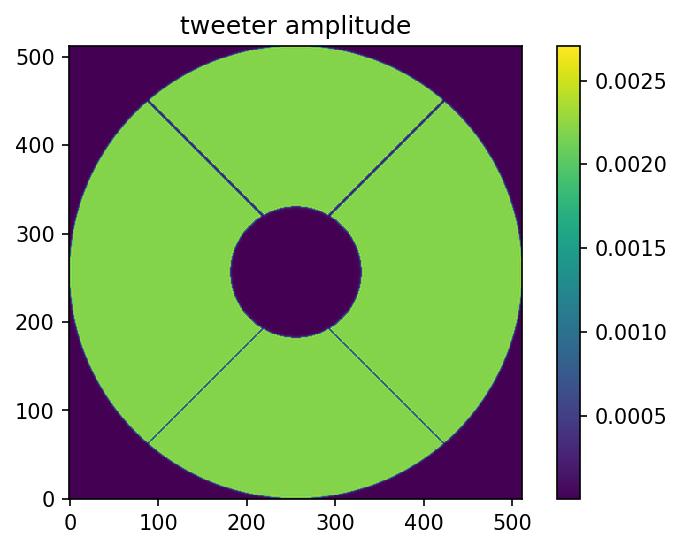

In [6]:
tw_amp = poppy.utils.pad_or_crop_to_shape(tw_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=150)
plt.imshow(tw_amp, origin='lower')
plt.colorbar()
plt.title('tweeter amplitude')

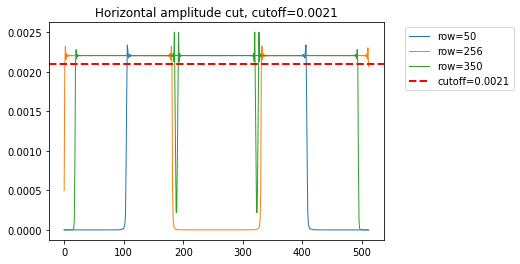

In [7]:
amp_cutoff = 0.0021
row_set = [50, 256, 350]
for j in range(0, len(row_set)):
    plt.plot(tw_amp[row_set[j]], linewidth=1, label='row={0}'.format(row_set[j]))
plt.axhline(y=amp_cutoff, color='r', linestyle='--', 
            linewidth=2, label='cutoff={0}'.format(amp_cutoff))
plt.title('Horizontal amplitude cut, cutoff={0}'.format(amp_cutoff))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

Text(0.5, 1.0, 'Tweeter phase, amplitude mask cutoff=0.0021')

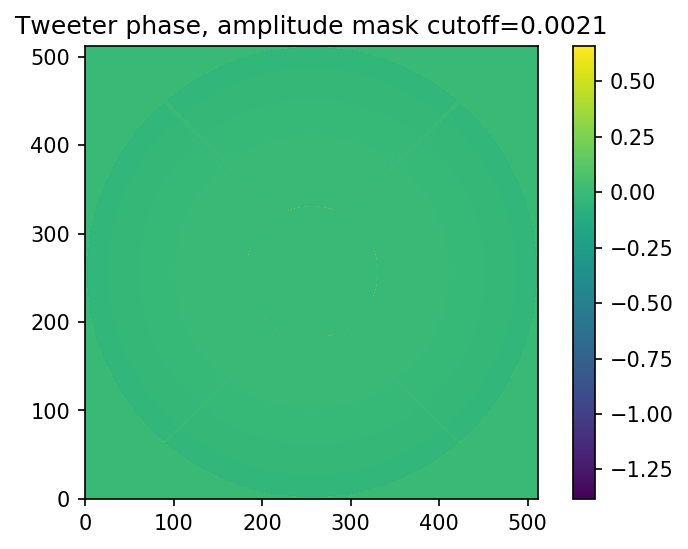

In [8]:
tw_amp_mask = (tw_amp > amp_cutoff) * 1.0 * np.flipud(pupil_mask)
tw_ph_mask = tw_amp_mask*tw_ph
plt.figure(dpi=150)
plt.imshow(tw_ph_mask, origin='lower')
plt.colorbar()
plt.clim(np.amin(tw_ph_qm), np.amax(tw_ph_qm))
plt.title('Tweeter phase, amplitude mask cutoff={0}'.format(amp_cutoff))

Text(0.5, 1.0, 'Tweeter mask, amplitude mask cutoff=0.0021')

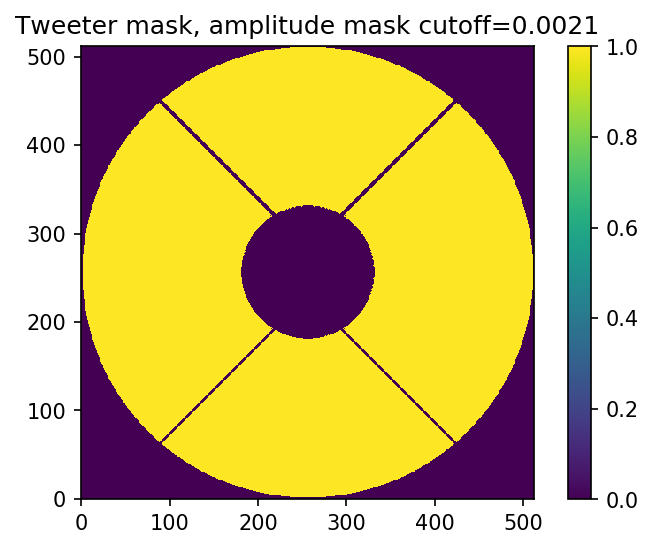

In [9]:
tw_amp_mask = (tw_amp > amp_cutoff) * 1.0 * np.flipud(pupil_mask)
plt.figure(dpi=150)
plt.imshow(tw_amp_mask, origin='lower')
plt.colorbar()
plt.title('Tweeter mask, amplitude mask cutoff={0}'.format(amp_cutoff))

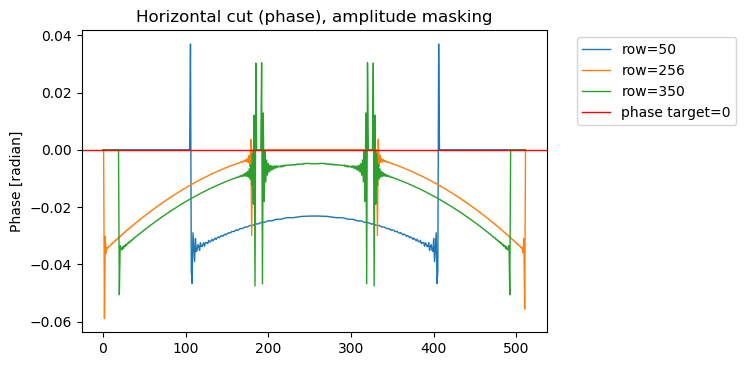

In [10]:
phase_cutoff = 0
row_set = [50, 256, 350]
plt.figure(dpi=100)
for j in range(0, len(row_set)):
    plt.plot(tw_ph_mask[row_set[j]], linewidth=1, label='row={0}'.format(row_set[j]))
plt.axhline(y=phase_cutoff, color='r', 
            linewidth=1, label='phase target={0}'.format(phase_cutoff))
plt.title('Horizontal cut (phase), amplitude masking')
plt.ylabel('Phase [radian]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

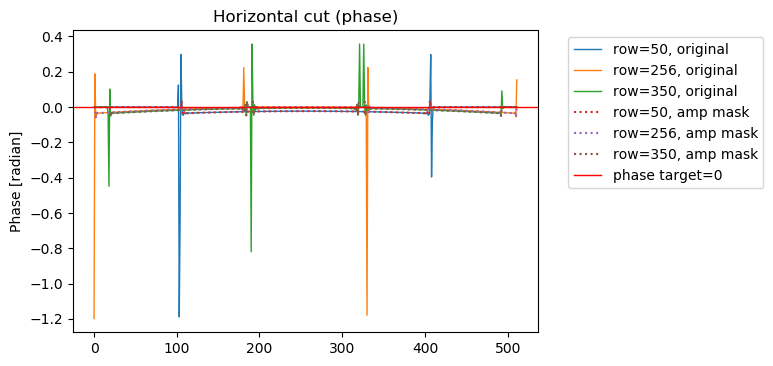

In [11]:
phase_cutoff = 0
row_set = [50, 256, 350]
plt.figure(dpi=100)
for j in range(0, len(row_set)):
    plt.plot(tw_ph_qm[row_set[j]], linewidth=1, label='row={0}, original'.format(row_set[j]))
for j in range(0, len(row_set)):
    plt.plot(tw_ph_mask[row_set[j]], ':', label='row={0}, amp mask'.format(row_set[j]))
plt.axhline(y=phase_cutoff, color='r', 
            linewidth=1, label='phase target={0}'.format(phase_cutoff))
plt.title('Horizontal cut (phase)')
plt.ylabel('Phase [radian]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Lyot Plane Analysis
Note that tweeter and lyot planes keep same parity.

In [12]:
%%time
n=0
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='LyotPlane')
ly_psf, ly_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

CPU times: user 54.7 s, sys: 12.9 s, total: 1min 7s
Wall time: 32.2 s


Text(0.5, 1.0, 'Lyot phase with pupil mask')

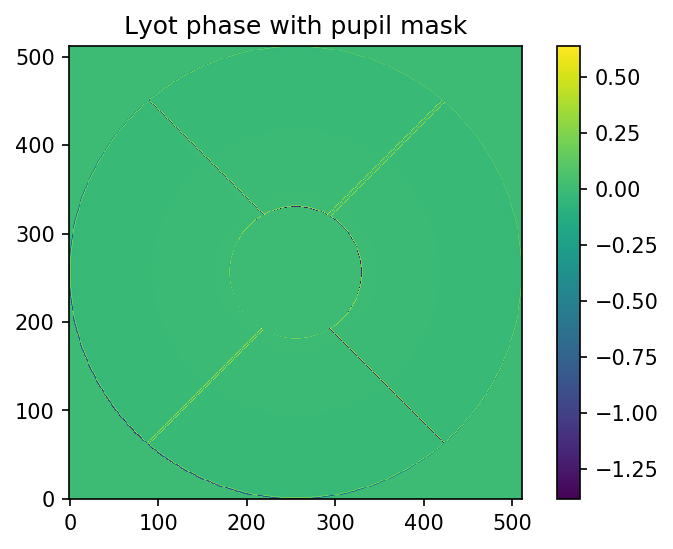

In [13]:
ly_ph = poppy.utils.pad_or_crop_to_shape(ly_wf[0].phase, (fr_parm['npix'], fr_parm['npix']))
ly_ph_qm = ly_ph*np.flipud(pupil_mask)
plt.figure(dpi=150)
plt.imshow(ly_ph_qm, origin='lower')
plt.colorbar()
plt.clim(np.amin(ly_ph_qm), np.amax(ly_ph_qm))
plt.title('Lyot phase with pupil mask')

Text(0.5, 1.0, 'Lyot amplitude')

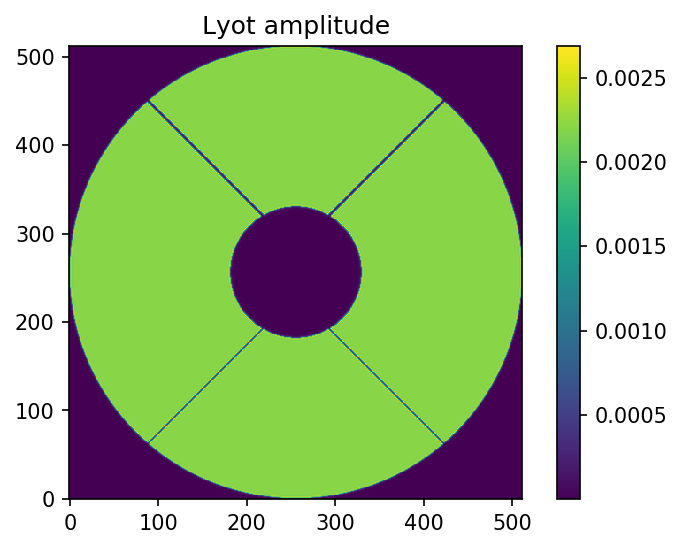

In [14]:
ly_amp = poppy.utils.pad_or_crop_to_shape(ly_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=150)
plt.imshow(ly_amp, origin='lower')
plt.colorbar()
plt.title('Lyot amplitude')

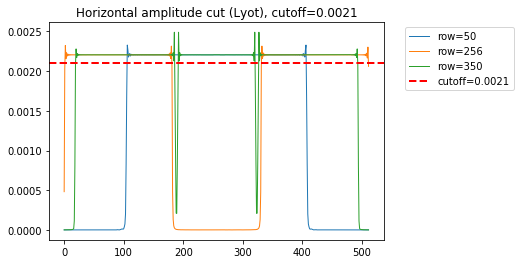

In [15]:
amp_cutoff = 0.0021
row_set = [50, 256, 350]
for j in range(0, len(row_set)):
    plt.plot(ly_amp[row_set[j]], linewidth=1, label='row={0}'.format(row_set[j]))
plt.axhline(y=amp_cutoff, color='r', linestyle='--', 
            linewidth=2, label='cutoff={0}'.format(amp_cutoff))
plt.title('Horizontal amplitude cut (Lyot), cutoff={0}'.format(amp_cutoff))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

Text(0.5, 1.0, 'Lyot phase, amplitude mask cutoff=0.0021')

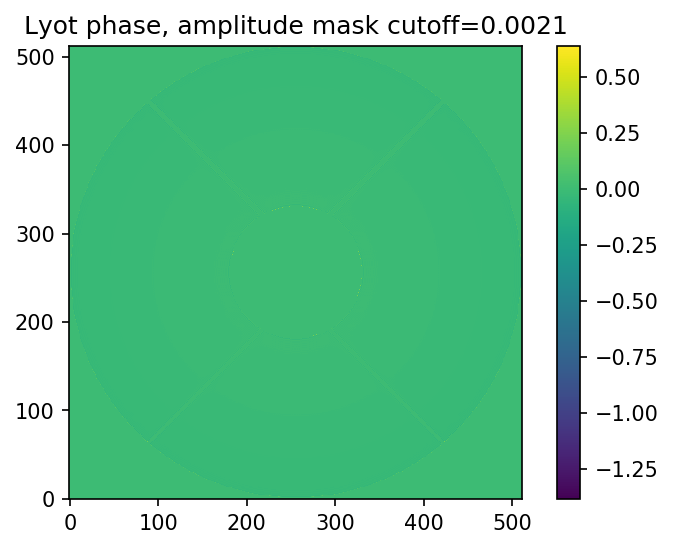

In [16]:
ly_amp_mask = (ly_amp > amp_cutoff) * 1.0 * np.flipud(pupil_mask)
ly_ph_mask = ly_amp_mask*ly_ph
plt.figure(dpi=150)
plt.imshow(ly_ph_mask, origin='lower')
plt.colorbar()
plt.clim(np.amin(ly_ph_qm), np.amax(ly_ph_qm))
plt.title('Lyot phase, amplitude mask cutoff={0}'.format(amp_cutoff))

Text(0.5, 1.0, 'Lyot mask, amplitude mask cutoff=0.0021')

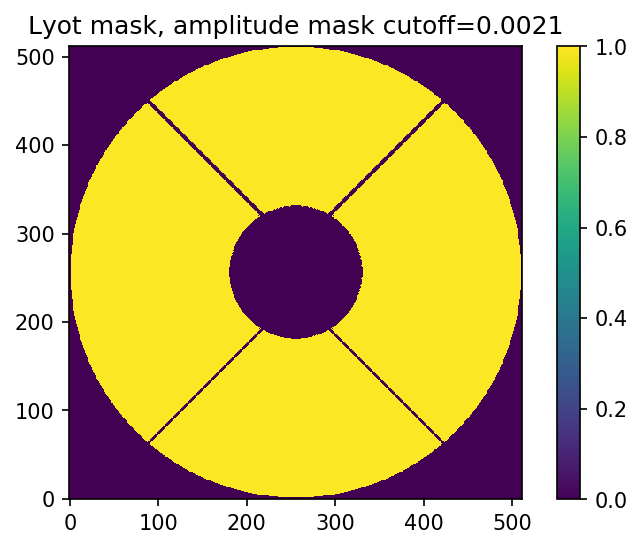

In [17]:
ly_amp_mask = (ly_amp > amp_cutoff) * 1.0 * np.flipud(pupil_mask)
plt.figure(dpi=150)
plt.imshow(ly_amp_mask, origin='lower')
plt.colorbar()
plt.title('Lyot mask, amplitude mask cutoff={0}'.format(amp_cutoff))

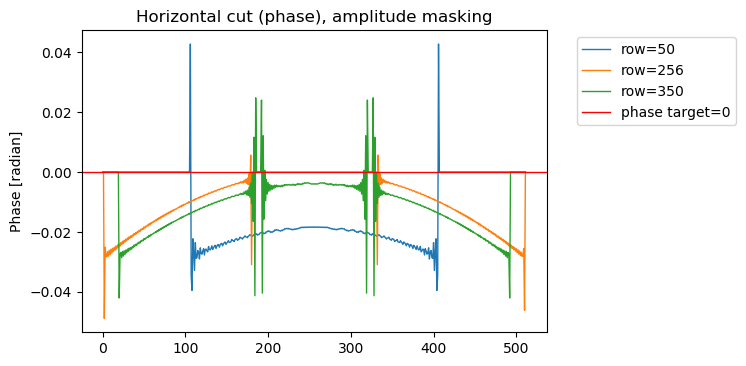

In [18]:
phase_cutoff = 0
row_set = [50, 256, 350]
plt.figure(dpi=100)
for j in range(0, len(row_set)):
    plt.plot(ly_ph_mask[row_set[j]], linewidth=1, label='row={0}'.format(row_set[j]))
plt.axhline(y=phase_cutoff, color='r', 
            linewidth=1, label='phase target={0}'.format(phase_cutoff))
plt.title('Horizontal cut (phase), amplitude masking')
plt.ylabel('Phase [radian]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

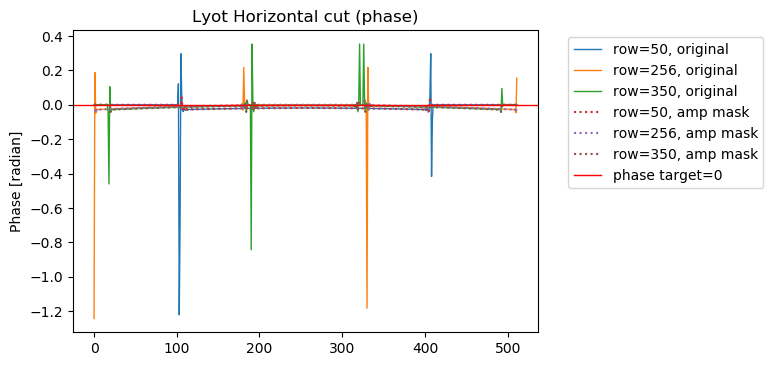

In [19]:
phase_cutoff = 0
row_set = [50, 256, 350]
plt.figure(dpi=100)
for j in range(0, len(row_set)):
    plt.plot(ly_ph_qm[row_set[j]], linewidth=1, label='row={0}, original'.format(row_set[j]))
for j in range(0, len(row_set)):
    plt.plot(ly_ph_mask[row_set[j]], ':', label='row={0}, amp mask'.format(row_set[j]))
plt.axhline(y=phase_cutoff, color='r', 
            linewidth=1, label='phase target={0}'.format(phase_cutoff))
plt.title('Lyot Horizontal cut (phase)')
plt.ylabel('Phase [radian]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Compare the pupil masks from each other

In [20]:
mask_diff = np.abs(tw_amp_mask.astype(int) - ly_amp_mask.astype(int))
np.sum(mask_diff)

6

In [21]:
np.sum(ly_amp_mask.astype(int) - tw_amp_mask.astype(int))

-6

### Save the Lyot pupil mask
Choose Lyot pupil mask because there's 6 less pixels active in Lyot pupil mask versus Tweeter pupil mask. Care more about what pixels that can be corrected.

In [22]:
ly_wf[0]._pixelscale_m

<Quantity 1.76280682e-05 m / pix>

In [23]:
ly_wf[0]._pixelscale_m * fr_parm['npix']*u.pix

<Quantity 0.00902557 m>

In [25]:
hdr = fits.Header()
hdr['pixscale'] = (ly_wf[0]._pixelscale_m.value, 
                   "pixelscale at pupil plane, [{0}]".format(ly_wf[0]._pixelscale_m.unit))
hdr['oversamp'] = (ly_wf[0].oversample,
                   "oversample value for Fresnel propagation")
fits.writeto('lyot_tweeter_amp_mask.fits', ly_amp_mask.astype(int), hdr, overwrite=True)